In [1]:
import sys
from torchsummary import summary
import ast
import torch
import random
import numpy as np
import icecream as ic
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
sys.path.append("../../")
sys.path.append("../")
####### Dataset ############
from data_processor import DataProcessor
######## Search space #########
from search_space.RegNet import RegNet
from search_space.utils import create_widths_plot, scatter_results, get_generation_dfs
######## Training ###############
from trainer import Trainer, TrainerDistillation
from utils.train_cfg import get_cfg, show_cfg
###################################################
random_seed = 1
random.seed(random_seed)
# Set seed for NumPy
np.random.seed(random_seed)
# Set seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
# Additional steps if using CuDNN (optional, for GPU acceleration)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
from datetime import datetime
import itertools
import pandas as pd
import json
from io import StringIO
from coolname import generate_slug
from sklearn.metrics import accuracy_score
import torch.multiprocessing as mp

/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load dataset

In [2]:
def load_dataset_metadata(dataset_path):
    with open(os.path.join(dataset_path, 'metadata'), "r") as f:
        metadata = json.load(f)
    return metadata
# load dataset from file
def load_datasets(data_path, truncate):
    data_path = '../../datasets/'+data_path
    train_x = np.load(os.path.join(data_path,'train_x.npy'))
    train_y = np.load(os.path.join(data_path,'train_y.npy'))
    valid_x = np.load(os.path.join(data_path,'valid_x.npy'))
    valid_y = np.load(os.path.join(data_path,'valid_y.npy'))
    test_x = np.load(os.path.join(data_path,'test_x.npy'))
    metadata = load_dataset_metadata(data_path)

    if truncate:
        train_x = train_x[:64]
        train_y = train_y[:64]
        valid_x = valid_x[:64]
        valid_y = valid_y[:64]
        test_x = test_x[:64]

    return (train_x, train_y), \
           (valid_x, valid_y), \
           (test_x), metadata

def validation(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 4. Calculate Accuracy
    accuracy = correct / total
    print('Accuracy on the test set: {:.2f}%'.format(accuracy * 100))

In [3]:
Dataset="AddNIST"
(train_x, train_y), (valid_x, valid_y), (test_x), metadata = load_datasets(Dataset, truncate=False)
test_y = np.load(os.path.join('../../datasets/'+Dataset,'test_y.npy'))
metadata["select_augment"]=False
data_processor = DataProcessor(train_x[:], train_y[:], valid_x, valid_y, test_x, metadata)
train_loader, valid_loader, test_loader = data_processor.process()


metadata

/apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-2.2.0/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


{'num_classes': 20,
 'input_shape': [50000, 3, 28, 28],
 'codename': 'Adaline',
 'benchmark': 89.85,
 'select_augment': False,
 'train_config_path': 'anki_lab_submission/configs/train/augmentations_adam.yaml'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


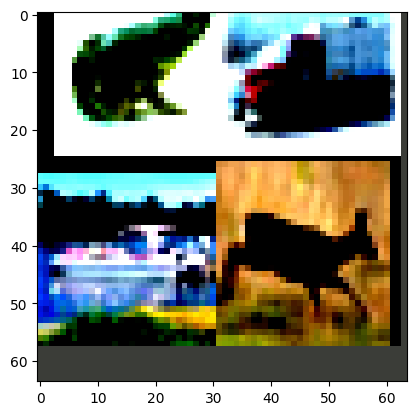

In [4]:
img=next(iter(train_loader))[0][0]
img=img.numpy().transpose(1, 2, 0)
plt.imshow(img)

# Load search space and population

In [64]:
rg=regnet_space=RegNet(metadata,
                    W0=[16, 120, 8],
                    WA=[16, 64, 8],
                    WM=[2.05,2.9,0.05],
                    D=[8,22,1], 
                    G=[8,8,8], 
                    base_config=f"../configs/search_space/config.yaml")

In [65]:
#model_best, info_best, _= regnet.load_model("output/test_regnet_cifar100/RegNetY800MF", weights_file="output/test_regnet_cifar100/RegNetY800MF/student_best")
#summary(model_best, (3,32,32))

In [66]:
    current_time=datetime.now().strftime("%d_%m_%Y_%H_%M")
    test_folder=f"{os.getenv('WORK')}/NAS_COMPETITION_RESULTS/kwnowledge_distillation/kd/{current_time}/{metadata['codename']}"
    
    folder=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{metadata['codename']}"
    models, chromosomes=rg.load_generation(folder)
    #models, chromosomes=rg.create_random_generation(save_folder=test_folder,gen=None, size=1, config_updates=None)

Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/emerald_aardwark/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/onyx_gaur/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/rampant_myna/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/succinct_chimpanzee/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/red_caterpillar/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/thistle_owl/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/mahogany_collie/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/quizzical_caiman/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULT

In [67]:
#rg.create_widths_plot(chromosomes)

# Load teacher (regnet)

In [68]:
    import torchvision.models as models_torch
    from utils.train_cfg import load_checkpoint
    # Train models
    SUBMISSION_PATH=".."
    metadata["train_config_path"]=f'{SUBMISSION_PATH}/configs/train/regnet_distillation_adam_test.yaml'
    train_cfg=get_cfg()
    train_cfg.merge_from_file(metadata["train_config_path"])
    os.makedirs(test_folder, exist_ok=True)
    output_file_path = f"{test_folder}/config.yaml"#
    
    with open(output_file_path, "w") as f:
            f.write(train_cfg.dump()) 

    models_names=sorted(list(models.keys()))[:] 
    multi=False
    #ic((get_gpu_memory(0) / (1024 ** 3)))
    ############################### Load resnet teacher model #################
    # save the results to a file
    aug_path=f"/home/hpc/iwb3/iwb3021h/NAS_CHALLENGE/NAS_Challenge_AutoML_2024/anki_lab_submission/tests/results/full_training_evonas/augmentations_test/{metadata['codename']}"
    print(aug_path)
    with open(f"{aug_path}/augmentation_results.json", 'r') as f:
        results = json.load(f)
    print(results)
    
    # Sort the dictionary by value in descending order
    # Sorting by 'val_acc'
    sorted_items = sorted(results.items(), key=lambda item: item[1]['val_acc'], reverse=True)
    print(sorted_items)
    print(f"First best key: {sorted_items[0][0]}")
    print(f"Second best key: {sorted_items[1][0]}")
    
    max_key = sorted_items[0][0] if sorted_items[0][0]!="0" else sorted_items[1][0]
    max_value = results[max_key]

    print(f'The key with the maximum value is "{max_key}" with a value of {max_value}.')

    



/home/hpc/iwb3/iwb3021h/NAS_CHALLENGE/NAS_Challenge_AutoML_2024/anki_lab_submission/tests/results/full_training_evonas/augmentations_test/Adaline
{'0': {'val_acc': 93.00666809082031, 'train_acc': 100.0, 'epoch_time': 8.457533359527588}, '1': {'val_acc': 79.26667022705078, 'train_acc': 99.99554443359375, 'epoch_time': 16.541600227355957}, '2': {'val_acc': 56.59333419799805, 'train_acc': 99.9065170288086, 'epoch_time': 16.808910846710205}, '3': {'val_acc': 18.80666732788086, 'train_acc': 63.078704833984375, 'epoch_time': 19.368762016296387}, '4': {'val_acc': 19.84000015258789, 'train_acc': 76.0973129272461, 'epoch_time': 20.979628324508667}, '5': {'val_acc': 91.55333709716797, 'train_acc': 99.5615234375, 'epoch_time': 11.082377195358276}, '6': {'val_acc': 92.73999786376953, 'train_acc': 97.33573913574219, 'epoch_time': 14.146133184432983}, '7': {'val_acc': 91.22666931152344, 'train_acc': 93.76780700683594, 'epoch_time': 11.500339031219482}, '8': {'val_acc': 92.16666412353516, 'train_acc'

In [69]:
    weights_file=f"{aug_path}/aug_{max_key}/student_best"
    teacher = models_torch.resnet18(weights=None)
    new_conv1 = torch.nn.Conv2d(in_channels=metadata["input_shape"][1], 
                            out_channels=teacher.conv1.out_channels, 
                            kernel_size=teacher.conv1.kernel_size, 
                            stride=teacher.conv1.stride, 
                            padding=teacher.conv1.padding, 
                            bias=teacher.conv1.bias)
    # Replace the first convolutional layer
    teacher.conv1 = new_conv1
    teacher.fc = torch.nn.Linear(512, metadata['num_classes'])
    state = load_checkpoint(weights_file)
    teacher.load_state_dict(state["model"])
    teacher.to(device)
    ########################################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
 weights_file="/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/kwnowledge_distillation/vanilla/16_08_2024_11_44/Mateo/awesome_dodo/student_best"
config_file=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{metadata['codename']}/awesome_dodo/config.yaml"
teacher, info_teacher=rg.load_model(config_file=config_file, weights_file=weights_file,  config_updates=None)
teacher.to(device)

Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/awesome_dodo/config.yaml


RegNet(
  (stem): ResStemCifar(
    (conv): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (af): ReLU(inplace=True)
  )
  (s1): AnyStage(
    (b1): ResBottleneckBlock(
      (f): BottleneckTransform(
        (a): Conv2d(28, 120, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (a_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (a_af): ReLU(inplace=True)
        (b): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=15, bias=False)
        (b_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (b_af): ReLU(inplace=True)
        (se): SE(
          (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
          (f_ex): Sequential(
            (0): Conv2d(120, 7, kernel_size=(1, 1), stride=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv

# Train student

In [60]:
from utils.train_cfg import  validate
import gc
from distillation.base import Vanilla

In [70]:
clear_output(wait=True)
distiller_teach=Vanilla(teacher)


In [71]:
validate(valid_loader, distiller_teach, 1)

(tensor(92.7267, device='cuda:0'),
 tensor(92.7267, device='cuda:0'),
 0.32277212351957957)

In [73]:
def train_mp(student,student_name,teacher,  metadata, test_folder, device, train_loader,valid_loader):
        
        clear_output(wait=True)
        metadata["experiment_name"]=f"{test_folder}/{student_name}"
        trainer=TrainerDistillation(student, device, train_loader, valid_loader,metadata, [teacher]) 
        trainer.train()
        torch.cuda.empty_cache()
        gc.collect()
        
for name in models_names[:1]:
    train_mp(models[name],name,teacher, metadata, test_folder, device, train_loader,valid_loader)


ic| 'Distiller created'


[EVAL] Best accuracy:79.59333801269531


In [16]:
models_names[:1]

['abiding_turaco']